In [ ]:
# Cell 1: Install required libraries (run only if not already installed)
import sys
!{sys.executable} -m pip install --quiet opencv-python-headless easyocr imutils matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 24.3 MB/s eta 0:00:00


— Imports and configuration

In [ ]:
# Cell 2: Imports and small config
import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt
import easyocr
import os

# Matplotlib inline settings for Jupyter (show images in output)
%matplotlib inline

# Path to the image file (change this to your image location)
IMAGE_PATH = "/content/major image (1).jpg"
# cv2 — OpenCV for image processing.

# numpy — array operations.

# imutils — convenient image utilities (e.g., grab_contours).

# matplotlib.pyplot — for showing images in notebook.

# easyocr — for OCR (reading text from image).

# os — for file checks.

# %matplotlib inline — ensures plots show inside the notebook.

# IMAGE_PATH — define this to the image filename you want to process.

In [ ]:
# Cell 3: Only if you're on Google Colab — upload interactive file
# If you're running locally, just place the image in the notebook folder and skip this.
try:
    from google.colab import files
    uploaded = files.upload()  # follow prompts to upload files
    # Update IMAGE_PATH to the first uploaded file automatically
    IMAGE_PATH = next(iter(uploaded.keys()))
    print("Uploaded:", IMAGE_PATH)
except Exception:
    # Not on Colab or user skipped uploading
    pass


Saving major image (1).jpg to major image (1) (1).jpg
Uploaded: major image (1) (1).jpg


In [ ]:
# Cell 4: Helper to display images nicely
def show_image(img, title="Image", cmap=None, figsize=(10, 6)):
    """Utility to display OpenCV images (BGR or grayscale) in matplotlib."""
    plt.figure(figsize=figsize)
    if len(img.shape) == 2:  # grayscale
        plt.imshow(img, cmap=cmap or 'gray')
    else:
        # OpenCV uses BGR — convert to RGB for correct colors in matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()


Original image shape (h, w, channels): (430, 637, 3)


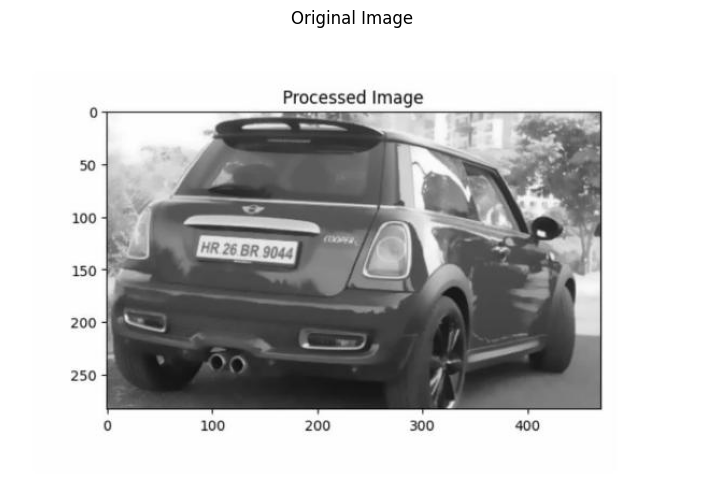

In [ ]:
# Cell 5: Load image from disk and sanity checks
if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found at {IMAGE_PATH}. Put the file in the notebook folder or change IMAGE_PATH.")

img = cv2.imread(IMAGE_PATH)  # reads as BGR
if img is None:
    raise ValueError("Failed to read image — maybe unsupported format or corrupted file.")
print("Original image shape (h, w, channels):", img.shape)
show_image(img, title="Original Image")


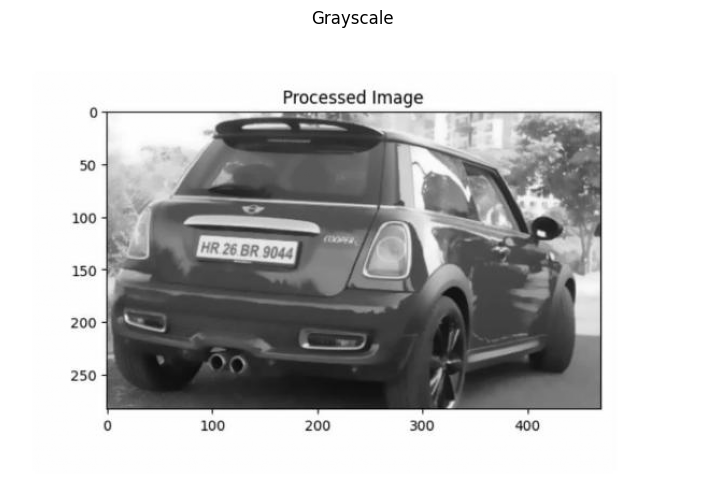

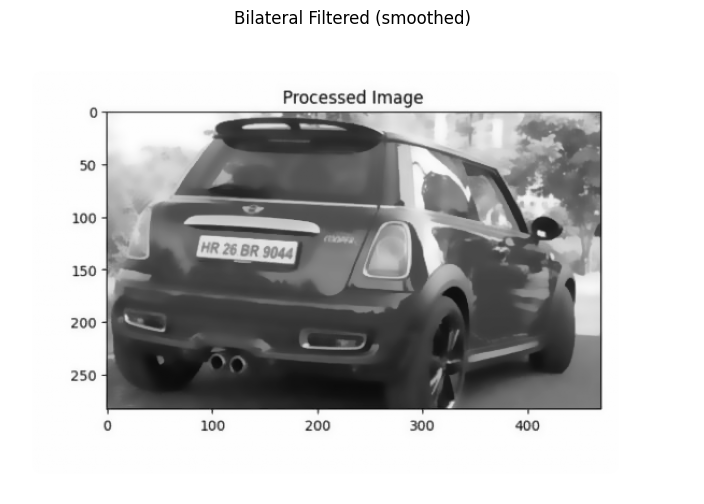

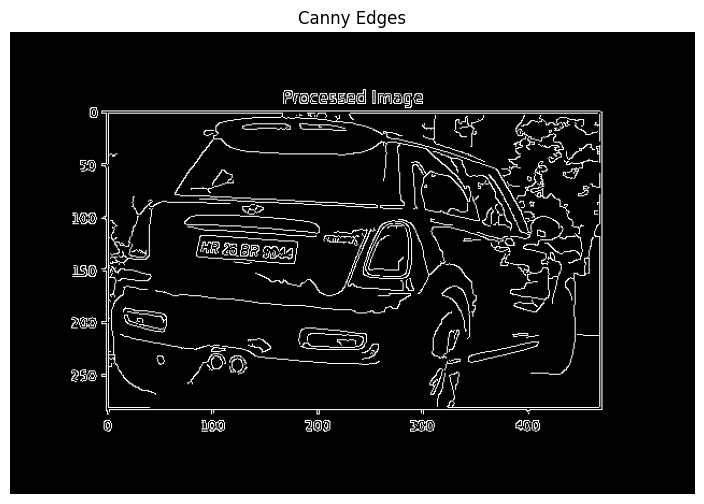

In [ ]:
# Cell 6: Preprocessing for contour detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                 # convert to grayscale
bfilter = cv2.bilateralFilter(gray, d=11, sigmaColor=17, sigmaSpace=17)  # smooth but keep edges
edged = cv2.Canny(bfilter, threshold1=30, threshold2=200)   # edge detection

show_image(gray, title="Grayscale")
show_image(bfilter, title="Bilateral Filtered (smoothed)")
show_image(edged, title="Canny Edges", cmap='gray')


 Find contours and detect the plate-like rectangle

In [ ]:
# Cell 7: Find contours and pick the best rectangle (license plate candidate)
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]  # top 30 contours by area

location = None
for contour in cnts:
    # epsilon should be a small fraction of the contour perimeter:
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.018 * peri, True)
    # We expect the plate to be approximately rectangular (4 corners)
    if len(approx) == 4:
        location = approx
        break

if location is None:
    print("Warning: No 4-corner contour found. Trying alternative strategy (bounding rect of largest contour).")
    if len(cnts) > 0:
        # fallback: use bounding rectangle of the largest contour
        x, y, w, h = cv2.boundingRect(cnts[0])
        location = np.array([[[x, y]], [[x+w, y]], [[x+w, y+h]], [[x, y+h]]])
    else:
        raise RuntimeError("No contours found in the image.")


<!-- findContours finds closed curves in edge image.

imutils.grab_contours adapts returned shape to a consistent format.

Sort contours by area and consider top 30 to speed up and avoid tiny contours.

For each contour:

arcLength measures perimeter.

approxPolyDP approximates contour shape; 0.018 * peri is a good epsilon for plates.

If approximation has 4 points, we assume it’s the plate rectangle.

If nothing found, fallback: use bounding rectangle of largest contour. -->

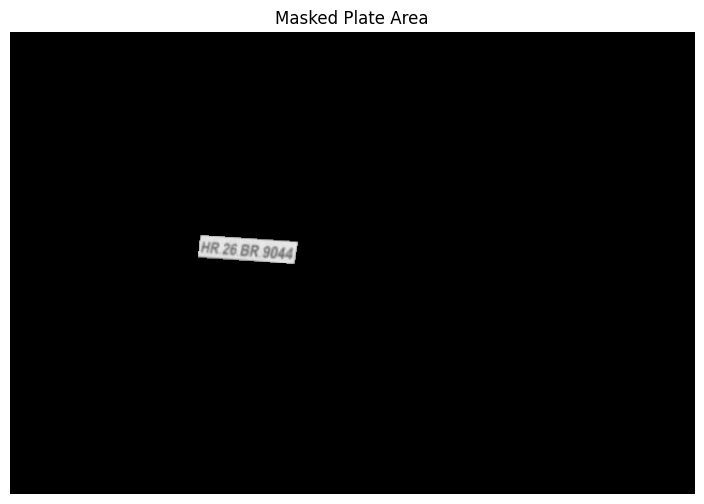

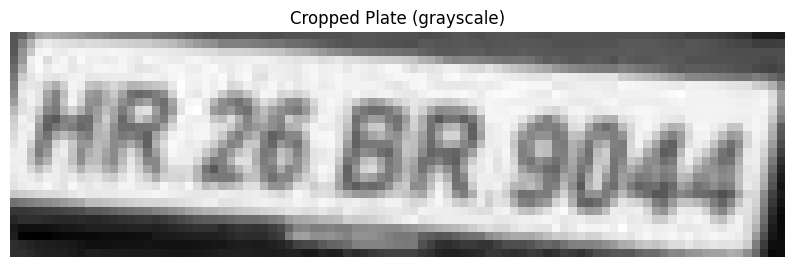

In [ ]:
#  Masking and cropping the detected plate region
 # Cell 8: Create mask and crop area inside the detected plate-contour
mask = np.zeros(gray.shape, dtype=np.uint8)
cv2.drawContours(mask, [location], 0, 255, -1)   # fill the plate region on mask

# Bitwise-AND to keep only the plate area from the original image
masked = cv2.bitwise_and(img, img, mask=mask)
show_image(masked, title="Masked Plate Area")

# Crop to the bounding box of the mask:
ys, xs = np.where(mask == 255)
if ys.size == 0 or xs.size == 0:
    raise RuntimeError("Mask is empty — plate region wasn't isolated correctly.")
x1, x2 = np.min(xs), np.max(xs)
y1, y2 = np.min(ys), np.max(ys)
cropped = gray[y1:y2+1, x1:x2+1]  # cropped in grayscale for OCR
show_image(cropped, title="Cropped Plate (grayscale)", cmap='gray')


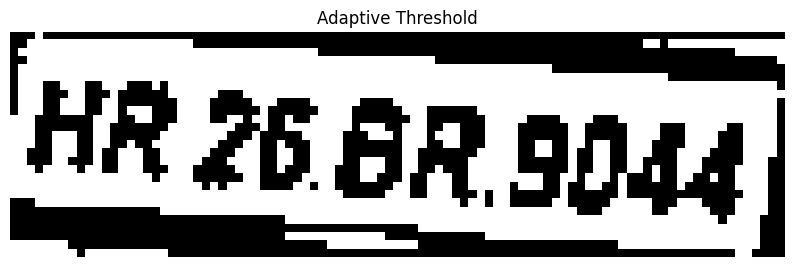

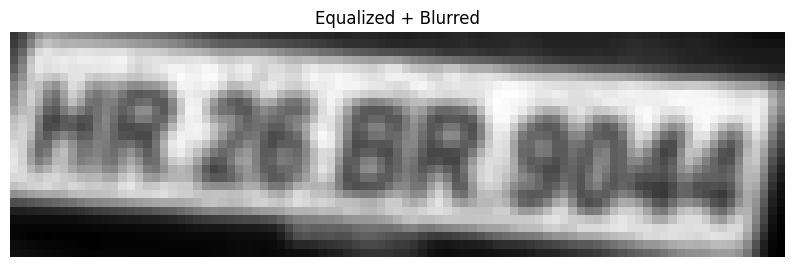

In [ ]:
#  Optional: improve contrast / thresholding for OCR
# Cell 9: Optional image enhancement to help OCR (try both and pick better)
# 1) Simple adaptive threshold
thresh = cv2.adaptiveThreshold(cropped, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)

# 2) Histogram equalization then Gaussian blur
eq = cv2.equalizeHist(cropped)
eq_blur = cv2.GaussianBlur(eq, (3,3), 0)

show_image(thresh, title="Adaptive Threshold")
show_image(eq_blur, title="Equalized + Blurred")


In [ ]:
#  OCR with EasyOCR (safe checks)
# Cell 10: Run OCR on the cropped plate area (try a couple of preprocessing options)
reader = easyocr.Reader(['en'], gpu=False)  # set gpu=True if you have GPU and proper setup

# Try OCR on different preprocessed variants (priority order)
variants = [cropped, thresh, eq_blur]
ocr_results = []

for v in variants:
    try:
        result = reader.readtext(v)
        # result is list of tuples: (bbox, text, confidence)
        if result:
            ocr_results.append(result)
    except Exception as e:
        print("EasyOCR error on variant:", e)

# Select the best OCR result if any
if ocr_results:
    # choose the result with highest average confidence
    scored = []
    for res in ocr_results:
        confidences = [r[2] for r in res]
        avg_conf = sum(confidences) / len(confidences) if confidences else 0
        scored.append((avg_conf, res))
    best = max(scored, key=lambda x: x[0])[1]
    # Typically the most confident bounding box text is the plate
    plate_texts = [r[1] for r in best]
    detected_text = " ".join(plate_texts).strip()
    print("Detected text (raw OCR):", detected_text)
else:
    detected_text = ""
    print("No text detected by EasyOCR.")


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Detected text (raw OCR): MR 26 BR 9044


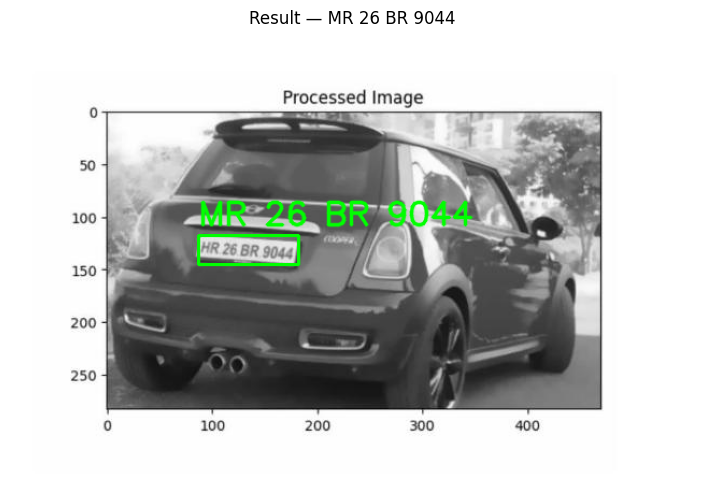

In [ ]:
# Postprocess the OCR result and draw on original image
# Cell 11: Clean the text and annotate the original image
def clean_plate_text(text):
    # Keep uppercase alphanumerics and common separators, remove weird chars
    import re
    cleaned = re.sub(r'[^A-Z0-9\- ]+', '', text.upper())
    cleaned = re.sub(r'\s{2,}', ' ', cleaned).strip()
    return cleaned

final_text = clean_plate_text(detected_text) if detected_text else "UNREADABLE"

# Draw rectangle and text on original image (using bounding box coordinates)
try:
    # use bounding rectangle of detected location (x, y, w, h)
    x, y, w, h = cv2.boundingRect(location)
    annotated = img.copy()
    cv2.rectangle(annotated, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(annotated, final_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                1.0, (0, 255, 0), 2, cv2.LINE_AA)
    show_image(annotated, title=f"Result — {final_text}")
except Exception as e:
    print("Could not annotate result:", e)
    show_image(img, title="Original (no annotation)")


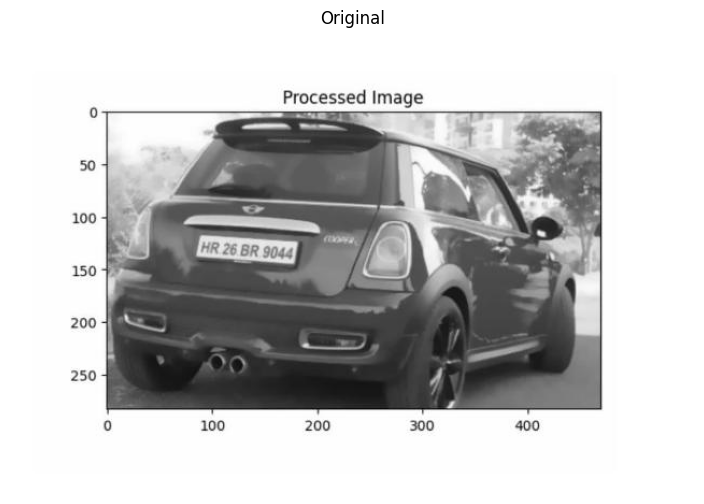

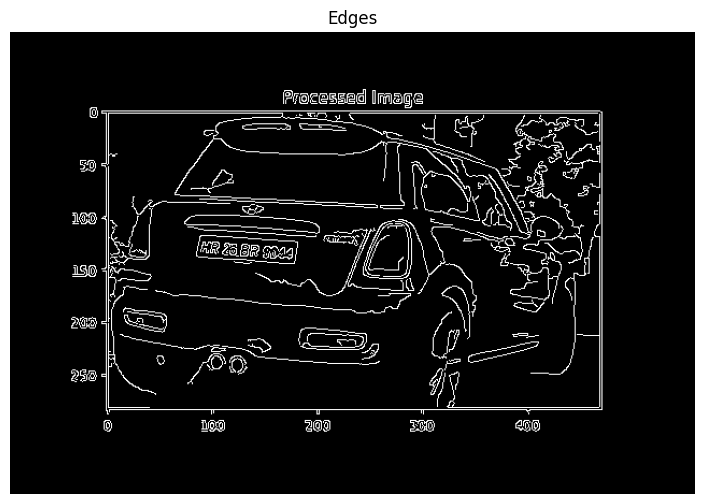

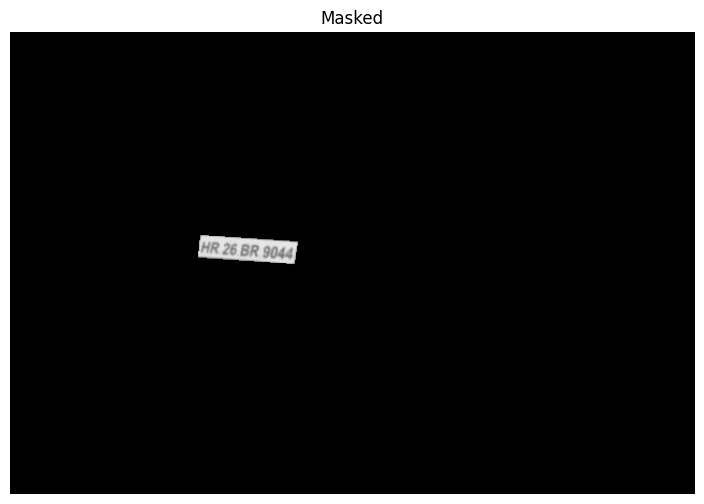

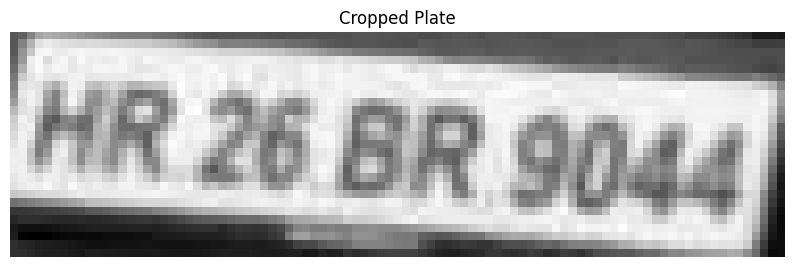

Detected plate text: MR 26 BR 9044


In [ ]:
# Wrap everything in a function (optional) for re-use
# Cell 12: One function to run full pipeline for a given image path
def detect_plate(image_path, show_steps=False):
    if not os.path.exists(image_path):
        raise FileNotFoundError("Image not found: " + image_path)
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(bfilter, 30, 200)
    cnts = imutils.grab_contours(cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE))
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]
    location = None
    for contour in cnts:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.018 * peri, True)
        if len(approx) == 4:
            location = approx
            break
    if location is None:
        if len(cnts) > 0:
            x, y, w, h = cv2.boundingRect(cnts[0])
            location = np.array([[[x, y]], [[x+w, y]], [[x+w, y+h]], [[x, y+h]]])
        else:
            return None, "NoContours"
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.drawContours(mask, [location], 0, 255, -1)
    ys, xs = np.where(mask == 255)
    if ys.size == 0:
        return None, "EmptyMask"
    x1, x2 = np.min(xs), np.max(xs)
    y1, y2 = np.min(ys), np.max(ys)
    cropped = gray[y1:y2+1, x1:x2+1]
    # OCR attempts
    reader = easyocr.Reader(['en'], gpu=False)
    # variants
    thresh = cv2.adaptiveThreshold(cropped, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    eq = cv2.equalizeHist(cropped)
    eq_blur = cv2.GaussianBlur(eq, (3,3), 0)
    variants = [cropped, thresh, eq_blur]
    best_text = ""
    best_conf = -1
    for v in variants:
        res = reader.readtext(v)
        if res:
            avg_conf = sum([r[2] for r in res]) / len(res)
            txt = " ".join([r[1] for r in res]).strip()
            if avg_conf > best_conf:
                best_conf = avg_conf
                best_text = txt
    clean = clean_plate_text(best_text) if best_text else ""
    # annotate
    x, y, w, h = cv2.boundingRect(location)
    annotated = image.copy()
    display_text = clean if clean else "UNREADABLE"
    cv2.rectangle(annotated, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(annotated, display_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                1.0, (0, 255, 0), 2, cv2.LINE_AA)
    if show_steps:
        show_image(image, title="Original")
        show_image(edged, title="Edges", cmap='gray')
        show_image(masked := cv2.bitwise_and(image, image, mask=mask), title="Masked")
        show_image(cropped, title="Cropped Plate", cmap='gray')
    return annotated, display_text

# Example usage:
annotated_img, plate_text = detect_plate(IMAGE_PATH, show_steps=True)
print("Detected plate text:", plate_text)
